# In truncation selection individuals are sorted according to their fitness. Only the best individuals are selected for parents. These selected parents produce uniform at random offspring. 

#The parameter for truncation selection is the truncation threshold Trunc. Trunc indicates the proportion of the population to be selected as parents and takes values ranging from 50%-10%. Individuals below the truncation threshold do not produce offspring. 

# The term selection intensity is often used in truncation selection. Table shows the relation between both.

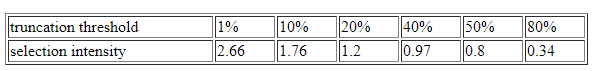

# **The TSP problem**

We will use a GA to find a solution to the traveling salesman problem (TSP). 
Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?

There are two rules:

1. Each city needs to be visited exactly one time
2. We must return to the starting city, so our total distance needs to be calculated accordingly.



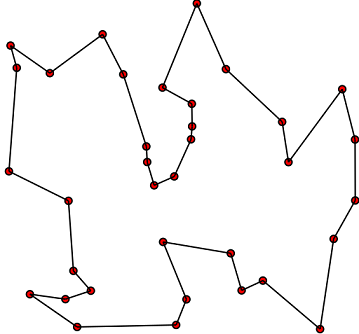

# **Formulation of the TSP problem with GA concepts**

**Gene:** a city (represented as (x, y) coordinates)

**Individual (or “chromosome”):** a single route satisfying the conditions above

**Population:** a collection of possible routes (i.e., collection of individuals)

**Parents:** two routes that are combined to create a new route

**Mating pool:** a collection of parents that are used to create our next population (thus creating the next generation of routes)

**Fitness:** a function that tells us how good each route is (in our case, how short the distance is)

**Mutation:** a way to introduce variation in our population by randomly swapping two cities in a route

**Elitism:** a way to carry the best individuals into the next generation

In [ ]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

We first create a City class that will allow us to create and handle our cities.

In [ ]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [ ]:
 #First city
 x=int(random.random() * 200)
 print('x=',x)
 y=int(random.random() * 200)
 print('y=',y)
 a=City(x, y)
 print(City.__repr__(a))
 #Second city
 x=int(random.random() * 200)
 print('x=',x)
 y=int(random.random() * 200)
 print('y=',y)
 a2=City(x, y)
 print(City.__repr__(a2))
 print('Distance between a2 and a',a2.distance(a))

x= 69
y= 126
(69,126)
x= 101
y= 8
(101,8)
Distance between a2 and a 122.2620137246234


We create a Fitness class. In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better. In the TSP problem, we need to start and end at the same place, so this rule is taken into consideration in the distance calculation.

In [ ]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

We create an initial population (which is considered as the  first generation). We need a way to create a function that produces routes that satisfy our conditions (Note: we’ll create our list of cities when we actually run the GA at the end). To create an individual, we randomly select the order in which we visit each city.

In [ ]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

By looping through the createRoute function until we have as many routes as we want for our population.

In [ ]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

The fitness function is used to rank each individual in the population. The output will be an ordered list with the route IDs and each associated fitness score.

In [ ]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

First, we’ll use the output from rankRoutes to determine which routes to select in our selection function. 

# **!!! Add your selection technique here !!!**

Ultimately, the selection function returns a list of route IDs, which we can use to create the mating pool in the matingPool function.

In [ ]:
def truncation(Truncation_param, population):
    selectionResults = []
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    popRanked = sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)
    for i in range(0, len(population)):
        r = random.randint((1 - Truncation_param) * len(population), len(population)-1)
        selectionResults.append(popRanked[r][0])
    return selectionResults

Now that we have the IDs of the routes that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [ ]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In ordered crossover, we randomly select a subset of the first parent string (in crossover function below) and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent.


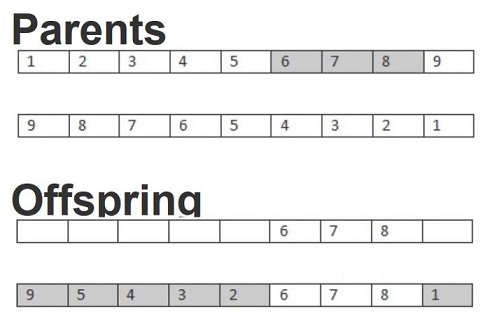

In [ ]:
def crossover(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

 We use elitism to retain the best routes from the current population. Then, we use the crossover function to fill out the rest of the next generation.

In [ ]:
def crossoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = crossover(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

**Mutation** helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. 

In the TSP problem, we can’t drop cities. Instead, we’ll use swap mutation. This means that, with specified low probability, two cities will swap places in our route. We’ll do this for one individual in our mutate function.

In [ ]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [ ]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

We now create a function that produces a new generation. First, we rank the routes in the current generation using **rankRoutes**. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the **matingPool** function. Finally, we then create our new generation using the **crossoverPopulation** function and then applying mutation using the **mutatePopulation** function.

In [ ]:
def nextGeneration(currentGen, eliteSize, Truncation_param, mutationRate):
    #pouplation = rankRoutes(currentGen)
    #Ranking will be done in the selection method
    selectionResults = truncation(Truncation_param, currentGen)
    matingpool = matingPool(currentGen, selectionResults)
    children = crossoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

We create 25 random cities.

In [ ]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

We consider 100 individuals in each generation, keep 20 elite individuals, use a 1% mutation rate for a given gene, and run through 500 generations:

In [ ]:
def geneticAlgorithmPlot(population, popSize, eliteSize, Truncation_param, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, Truncation_param, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

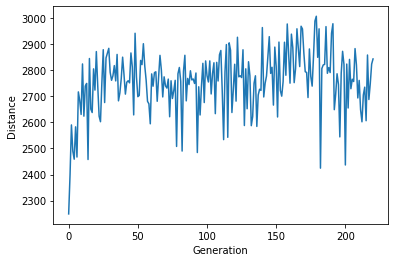

In [ ]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, Truncation_param=0.5, mutationRate=0.01, generations=220)